# **Protein-Protein Interaction Networks (PPIN)**

This document aims to facilitate the analysis of PPIN as a tool for identifying biomarkers.

In [ ]:
# Installation of libraries necessary for network analysis
#!pip show python-louvain
#!pip install python-louvain

In [1]:
# Importing necessary libraries
import os
import sys
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import community.community_louvain as community_louvain
import matplotlib.patches as mpatches
import seaborn as sns 
from collections import Counter
import seaborn as sns
from scipy.stats import mannwhitneyu
from collections import defaultdict

In [2]:
# Reading the network data from a TSV file
df = pd.read_csv("string_interactions_short.tsv", sep="\t")
# Displaying the first few rows of the dataframe
df.head()

,#node1,node2,combined_score
0,CD4,LCP2,891
1,ARF5,ACAP1,825
2,CD4,ICAM3,707
3,CD4,TNFRSF1A,797
4,GRN,TNFRSF1A,803


**Exploratory analysis of the raw network**


In [3]:
# Dimensions of the data frame
print("Data frame dimensions:", df.shape)
# Number of nodes (proteins)
print("Number of proteins:", df['#node1'].nunique() + df['node2'].nunique())
# Number of interactions 
print("Number of interactions:", df.shape[0])

Data frame dimensions: (5845, 3)
Number of proteins: 2616
Number of interactions: 5845


In [4]:
# Display the columns of the DataFrame
df.columns
# Display the first few rows of the DataFrame
print("Data type:")
print(df.dtypes)

Data type:
#node1            object
node2             object
combined_score     int64
dtype: object


In [5]:
# Creating the network from the DataFrame
G = nx.from_pandas_edgelist(
    df,
    source="#node1",                 # first node
    target="node2",                 # second node
    edge_attr="combined_score",     # edge attribute
    create_using=nx.Graph()         # create an undirected graph
)


In [6]:
# Summary statistics of the network

# 1. Number of nodes and edges
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# 2. Degrees and average number of neighbors
avg_neighbors = sum(dict(G.degree()).values()) / num_nodes

# 3. Connected components
connected_components = list(nx.connected_components(G))
num_components = len(connected_components)

# Select the largest component for path-based calculations
largest_cc = G.subgraph(max(connected_components, key=len)).copy()

# 4. Diameter and radius of the largest connected component
diameter = nx.diameter(largest_cc)
radius = nx.radius(largest_cc)

# 5. Long characteristic path length
char_path_length = nx.average_shortest_path_length(largest_cc)

# 6. Clustering coefficient
clustering_coeff = nx.average_clustering(G)

# 7. Network density
density = nx.density(G)

# 8. Network heterogeneity
degrees = [d for n, d in G.degree()]
heterogeneity = np.std(degrees) / np.mean(degrees)

# 9. Network centralization: centralization is calculated based on degree centrality
centralities = nx.degree_centrality(G)
max_cent = max(centralities.values())
centralization = sum(max_cent - c for c in centralities.values()) / (num_nodes - 1)

# 10. Summary statistics
print("Network Summary Statistics:")
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Avg. number of neighbors: {avg_neighbors:.3f}")
print(f"Network diameter: {diameter}")
print(f"Network radius: {radius}")
print(f"Characteristic path length: {char_path_length:.3f}")
print(f"Clustering coefficient: {clustering_coeff:.3f}")
print(f"Network density: {density:.3f}")
print(f"Network heterogeneity: {heterogeneity:.3f}")
print(f"Network centralization: {centralization:.3f}")
print(f"Connected components: {num_components}")

Network Summary Statistics:
Number of nodes: 2293
Number of edges: 5840
Avg. number of neighbors: 5.094
Network diameter: 16
Network radius: 8
Characteristic path length: 4.969
Clustering coefficient: 0.211
Network density: 0.002
Network heterogeneity: 1.626
Network centralization: 0.073
Connected components: 41


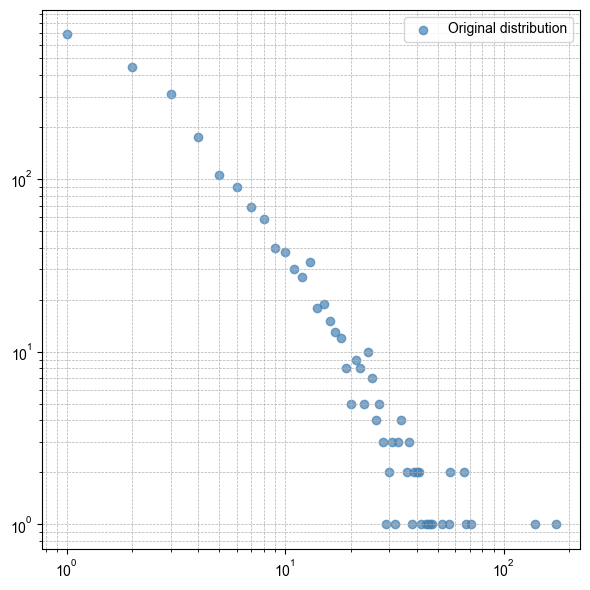

In [7]:
# Is the network scale-free?
# To determine if the network is scale-free, we can analyze the degree distribution.
# Calculate the degree distribution
degree_sequence = [d for n, d in G.degree()]
degree_count = Counter(degree_sequence)

# Sort the degree distribution
deg, cnt = zip(*sorted(degree_count.items()))

# Plotting the degree distribution
# Type of texts in the plot
plt.rcParams['font.family'] = 'Arial'
plt.figure(figsize=(6, 6))
plt.scatter(deg, cnt, color='steelblue', alpha=0.7, label='Original distribution')
#plt.scatter(deg, cnt, color='steelblue', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
#plt.xlabel("Degree (k)")
#plt.ylabel("Frequency (P(k))")
#plt.xlabel("Grado (k)")
#plt.ylabel("Frecuencia (P(k))")
#plt.title("Degree Distribution (Log-Log Scale)")
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
# Save & show plot
#plt.savefig("free_scale_rawnetwork.tiff", dpi=600, bbox_inches='tight')
plt.show()


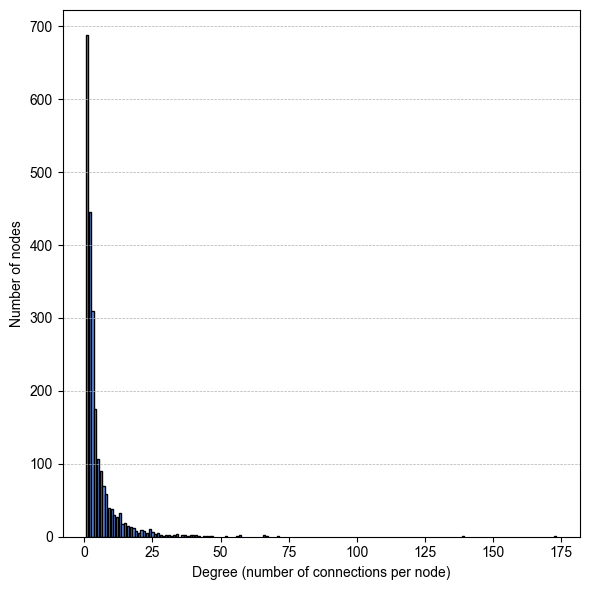

In [8]:
# Scale-free network 
# To determine if the network is scale-free, we can analyze the degree distribution.
# Calculate the degree distribution
degree_sequence = [d for n, d in G.degree()]
degree_count = Counter(degree_sequence)

# Sort the degree distribution
degrees, counts = zip(*sorted(degree_count.items()))

# Plotting the degree distribution 
plt.figure(figsize=(6,6))
plt.bar(degrees, counts, width=0.80, color='cornflowerblue', edgecolor='black')
plt.xlabel("Degree (number of connections per node)")
plt.ylabel("Number of nodes")
#plt.title("Degree Distribution (Absolute Frequency)")
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

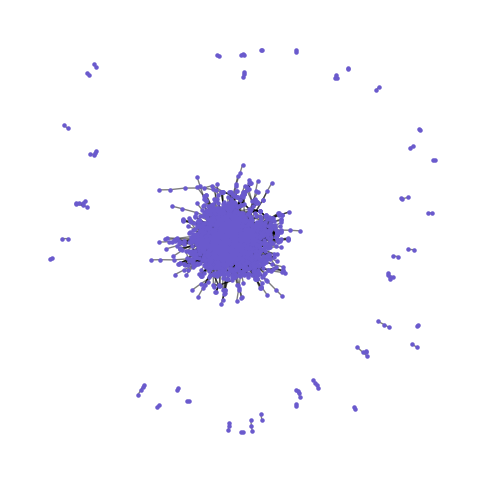

In [9]:
# Visualizing the network
# This visualization will help us understand the structure of the network.
plt.figure(figsize=(6, 6))
# Using a force-directed layout for better visualization
pos = nx.spring_layout(G, seed=42)
# Draw nodes 
nx.draw_networkx_nodes(G, pos, node_size=5, node_color='slateblue' , alpha=1.0)
# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.5)
# Remove axis for better visualization
plt.axis('off')
plt.show()


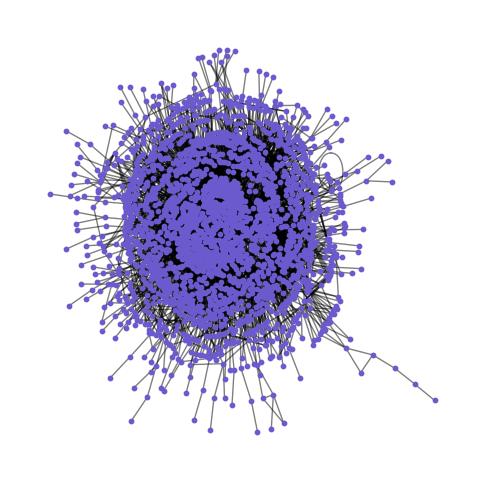

In [10]:
# Visualizing the network
# This visualization will help us understand the structure of the network.
plt.figure(figsize=(6, 6))
# Using a Kamada-Kawai layout for better visualization
pos = nx.kamada_kawai_layout(G)
# Drawing nodes
nx.draw_networkx_nodes(G, pos, node_size=10, node_color='slateblue' , alpha=1.0)
# Drawing edges
nx.draw_networkx_edges(G, pos, alpha=0.5)
# Remove axis for better visualization
plt.axis('off')
plt.show()

**Largest Subnetwork Analysis**

In [11]:
# Get all connected components as lists of nodes
components = list(nx.connected_components(G))
# Print the number of connected components
print(f"Number of nodes in the largest component: {len(components)}")
# Print the number of nodes in each component
for i, comp in enumerate(components):
    print(f"Component {i+1}: {len(comp)} nodes")


Number of nodes in the largest component: 41
Component 1: 2189 nodes
Component 2: 2 nodes
Component 3: 2 nodes
Component 4: 7 nodes
Component 5: 5 nodes
Component 6: 2 nodes
Component 7: 4 nodes
Component 8: 3 nodes
Component 9: 2 nodes
Component 10: 3 nodes
Component 11: 2 nodes
Component 12: 2 nodes
Component 13: 3 nodes
Component 14: 3 nodes
Component 15: 4 nodes
Component 16: 2 nodes
Component 17: 3 nodes
Component 18: 3 nodes
Component 19: 2 nodes
Component 20: 2 nodes
Component 21: 2 nodes
Component 22: 2 nodes
Component 23: 2 nodes
Component 24: 2 nodes
Component 25: 2 nodes
Component 26: 2 nodes
Component 27: 2 nodes
Component 28: 2 nodes
Component 29: 2 nodes
Component 30: 2 nodes
Component 31: 4 nodes
Component 32: 4 nodes
Component 33: 2 nodes
Component 34: 3 nodes
Component 35: 2 nodes
Component 36: 2 nodes
Component 37: 3 nodes
Component 38: 2 nodes
Component 39: 2 nodes
Component 40: 2 nodes
Component 41: 2 nodes


In [12]:
# Obtaining all connected components and selecting the largest one
# Get all connected components as lists of nodes
components = nx.connected_components(G)
# Find the largest component by length
largest_component_nodes = max(components, key=len)
# Create a subgraph with the largest component
G = G.subgraph(largest_component_nodes).copy()
# Display the number of nodes and edges in the largest component
print("Number of nodes (proteins):", G.number_of_nodes())
print("Number of edges (interactions):", G.number_of_edges())

Number of nodes (proteins): 2189
Number of edges (interactions): 5773


In [13]:
# Summary statistics of the network

# 1. Number of nodes and edges
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# 2. Degrees and average number of neighbors
avg_neighbors = sum(dict(G.degree()).values()) / num_nodes

# 3. Connected components
connected_components = list(nx.connected_components(G))
num_components = len(connected_components)

# Select the largest component for path-based calculations
largest_cc = G.subgraph(max(connected_components, key=len)).copy()

# 4. Diameter and radius of the largest connected component
diameter = nx.diameter(largest_cc)
radius = nx.radius(largest_cc)

# 5. Long characteristic path length
char_path_length = nx.average_shortest_path_length(largest_cc)

# 6. Clustering coefficient
clustering_coeff = nx.average_clustering(G)

# 7. Network density
density = nx.density(G)

# 8. Network heterogeneity
degrees = [d for n, d in G.degree()]
heterogeneity = np.std(degrees) / np.mean(degrees)

# 9. Network centralization: centralization is calculated based on degree centrality
centralities = nx.degree_centrality(G)
max_cent = max(centralities.values())
centralization = sum(max_cent - c for c in centralities.values()) / (num_nodes - 1)

# 10. Summary statistics
print("Network Summary Statistics:")
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Avg. number of neighbors: {avg_neighbors:.3f}")
print(f"Network diameter: {diameter}")
print(f"Network radius: {radius}")
print(f"Characteristic path length: {char_path_length:.3f}")
print(f"Clustering coefficient: {clustering_coeff:.3f}")
print(f"Network density: {density:.3f}")
print(f"Network heterogeneity: {heterogeneity:.3f}")
print(f"Network centralization: {centralization:.3f}")
print(f"Connected components: {num_components}")

Network Summary Statistics:
Number of nodes: 2189
Number of edges: 5773
Avg. number of neighbors: 5.275
Network diameter: 16
Network radius: 8
Characteristic path length: 4.969
Clustering coefficient: 0.218
Network density: 0.002
Network heterogeneity: 1.599
Network centralization: 0.077
Connected components: 1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


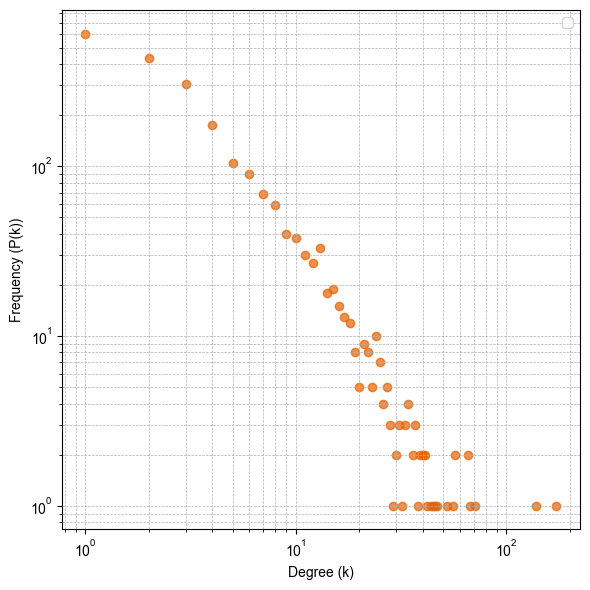

In [14]:
# Is the network scale-free?
# To determine if the network is scale-free, we can analyze the degree distribution.
# Calculate the degree distribution
degree_sequence = [d for n, d in G.degree()]
degree_count = Counter(degree_sequence)

# Sort the degree distribution
deg, cnt = zip(*sorted(degree_count.items()))

# Plotting the degree distribution
# Type of texts in the plot
plt.rcParams['font.family'] = 'Arial'
plt.figure(figsize=(6, 6))
#plt.scatter(deg, cnt, color='steelblue', alpha=0.7, label='Original distribution')
plt.scatter(deg, cnt, color='#E66100', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Degree (k)")
plt.ylabel("Frequency (P(k))")
#plt.xlabel("Grado (k)")
#plt.ylabel("Frecuencia (P(k))")
#plt.title("Degree Distribution (Log-Log Scale)")
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
# Save & show plot
plt.savefig("free_scale_largest_subnetwork_hncss.tiff", dpi=600, bbox_inches='tight')
plt.show()


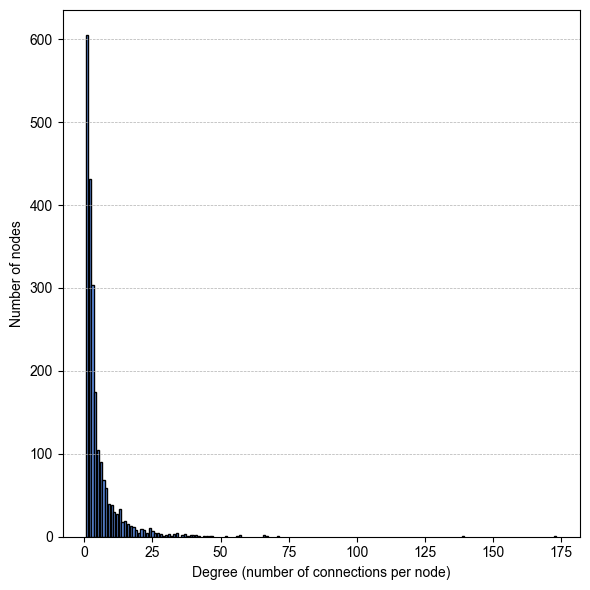

In [15]:
# Scale-free network 
# To determine if the network is scale-free, we can analyze the degree distribution.
# Calculate the degree distribution
degree_sequence = [d for n, d in G.degree()]
degree_count = Counter(degree_sequence)

# Sort the degree distribution
degrees, counts = zip(*sorted(degree_count.items()))

# Plotting the degree distribution 
plt.figure(figsize=(6,6))
plt.bar(degrees, counts, width=0.80, color='cornflowerblue', edgecolor='black')
plt.xlabel("Degree (number of connections per node)")
plt.ylabel("Number of nodes")
#plt.title("Degree Distribution (Absolute Frequency)")
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

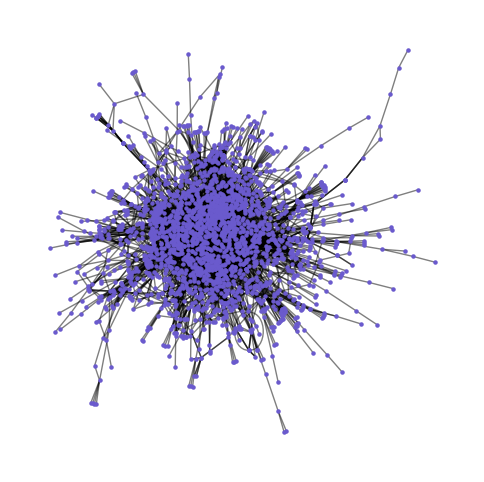

In [16]:
# Visualizing the network
# This visualization will help us understand the structure of the network.
plt.figure(figsize=(6, 6))
# Using a force-directed layout for better visualization
pos = nx.spring_layout(G, seed=42)
# Draw nodes 
nx.draw_networkx_nodes(G, pos, node_size=5, node_color='slateblue' , alpha=1.0)
# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.5)
# Remove axis for better visualization
plt.axis('off')
plt.show()


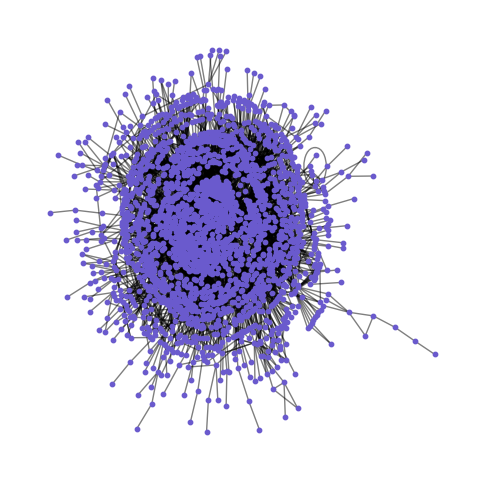

In [17]:
# Visualizing the network
# This visualization will help us understand the structure of the network.
plt.figure(figsize=(6, 6))
# Using a Kamada-Kawai layout for better visualization
pos = nx.kamada_kawai_layout(G)
# Drawing nodes
nx.draw_networkx_nodes(G, pos, node_size=10, node_color='slateblue' , alpha=1.0)
# Drawing edges
nx.draw_networkx_edges(G, pos, alpha=0.5)
# Remove axis for better visualization
plt.axis('off')
plt.show()

**Topology: centrality analysis**

In [18]:
# Calculating centrality measures and neighborhood metrics
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)
pagerank = nx.pagerank(G)

# Calculating clustering coefficient and neighborhood connectivity
clustering_coeff = nx.clustering(G)
# Neighborhood connectivity is defined as the average degree of the neighbors of each node
neighborhood_connectivity = {
    node: (sum(dict(G.degree(G.neighbors(node))).values()) / len(list(G.neighbors(node))))
    if len(list(G.neighbors(node))) > 0 else 0
    for node in G.nodes()
}

# Creating a DataFrame to summarize the centrality measures and neighborhood metrics
centralities_df = pd.DataFrame({
    "degree": pd.Series(degree_centrality),
    "betweenness": pd.Series(betweenness_centrality),
    "closeness": pd.Series(closeness_centrality),
    "eigenvector": pd.Series(eigenvector_centrality),
    "clustering_coeff": pd.Series(clustering_coeff),
    "neighborhood_connectivity": pd.Series(neighborhood_connectivity),
    'PageRank': [pagerank[n] for n in G.nodes()]
})

# Sorting the DataFrame by degree centrality
centralities_df = centralities_df.sort_values(by="degree", ascending=False)
# Displaying the first few rows of the centralities DataFrame
centralities_df.head()
# Note: the data contains normalized values of centrality measures, clustering coefficient, and neighborhood connectivity.

,degree,betweenness,closeness,eigenvector,clustering_coeff,neighborhood_connectivity,PageRank
TP53,0.079068,0.354186,0.349186,0.132889,0.015190,9.664740,0.013821
CD4,0.063528,0.114448,0.319137,0.367520,0.055990,15.064748,0.007777
MAPK3,0.032450,0.077407,0.314187,0.073445,0.042656,13.985915,0.004935
CCR7,0.030622,0.009549,0.267973,0.239379,0.144731,18.164179,0.003342
CD74,0.030165,0.028855,0.263996,0.060138,0.123077,14.575758,0.003433


In [19]:
# Exporting the centralities DataFrame to a CSV file
centralities_df.to_csv("network_centralities.csv", index=True)
print("Centralities DataFrame exported as 'network_centralities.csv'")

Centralities DataFrame exported as 'network_centralities.csv'


**Detection of communities: Louvain:**

To define communities using Louvain's modularity, it is necessary to establish the resolution of the communities.

Resolution 0.2: 377 communities
Resolution 0.4: 56 communities
Resolution 0.6: 59 communities
Resolution 0.8: 22 communities
Resolution 1.0: 22 communities
Resolution 1.2: 28 communities
Resolution 1.4: 28 communities
Resolution 1.6: 31 communities
Resolution 1.8: 34 communities
Resolution 2.0: 37 communities
Resolution 2.2: 39 communities
Resolution 2.4: 40 communities
Resolution 2.6: 46 communities
Resolution 2.8: 46 communities
Resolution 3.0: 50 communities


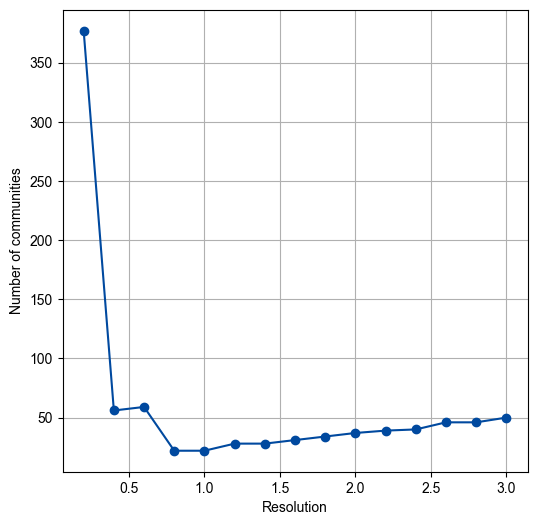

In [21]:
# List of resolution values to test in the Louvain algorithm
resolutions = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0]

# This list will store the number of communities detected at each resolution
num_communities = []

# Loop over each resolution value
for res in resolutions:
    # Apply the Louvain algorithm with the given resolution
    partition = community_louvain.best_partition(G, resolution=res, random_state=123)
    
    # Count how many unique communities were detected
    num_com = len(set(partition.values()))
    num_communities.append(num_com)
    
    # Print the number of communities for this resolution
    print(f"Resolution {res}: {num_com} communities")

# Plot the number of communities as a function of resolution
# Type of texts in the plot
plt.rcParams['font.family'] = 'Arial'
plt.figure(figsize=(6, 6))
plt.plot(resolutions, num_communities, marker='o', color='#00499F')
plt.xlabel('Resolution')
#plt.xlabel('Resolución')
plt.ylabel('Number of communities')
#plt.ylabel('Número de comunidades')
plt.grid(True)
# Save & show plot
plt.savefig("resolution_louvain_hnscc.tiff", dpi=600, bbox_inches='tight')
plt.show()


In [22]:
from networkx.algorithms.community.quality import modularity

modularities = []

for res in resolutions:
    partition = community_louvain.best_partition(G, resolution=res, random_state=123)
    
    # Calcular modularidad
    communities = [set([node for node in partition if partition[node] == comm_id])
                   for comm_id in set(partition.values())]
    mod = modularity(G, communities)
    modularities.append(mod)

    # También puedes imprimir la modularidad si deseas
    print(f"Resolution {res}: {len(communities)} communities, modularity = {mod:.3f}")


Resolution 0.2: 377 communities, modularity = 0.561
Resolution 0.4: 56 communities, modularity = 0.706
Resolution 0.6: 59 communities, modularity = 0.714
Resolution 0.8: 22 communities, modularity = 0.728
Resolution 1.0: 22 communities, modularity = 0.727
Resolution 1.2: 28 communities, modularity = 0.727
Resolution 1.4: 28 communities, modularity = 0.719
Resolution 1.6: 31 communities, modularity = 0.719
Resolution 1.8: 34 communities, modularity = 0.714
Resolution 2.0: 37 communities, modularity = 0.710
Resolution 2.2: 39 communities, modularity = 0.705
Resolution 2.4: 40 communities, modularity = 0.701
Resolution 2.6: 46 communities, modularity = 0.687
Resolution 2.8: 46 communities, modularity = 0.684
Resolution 3.0: 50 communities, modularity = 0.682


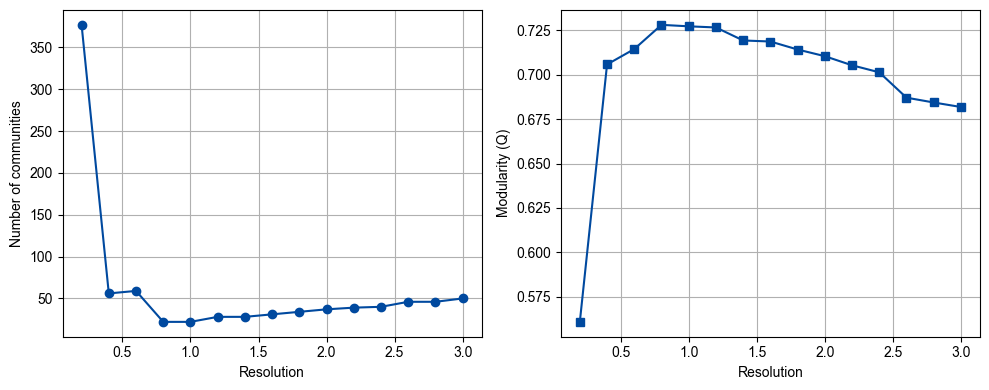

In [23]:
plt.figure(figsize=(10, 4))

# Subplot 1: Número de comunidades
# Type of texts in the plot
plt.rcParams['font.family'] = 'Arial'
plt.subplot(1, 2, 1)
plt.plot(resolutions, num_communities, marker='o', color='#00499F')
plt.xlabel('Resolution')
plt.ylabel('Number of communities')
#plt.title('Communities vs. Resolution')
#plt.xlabel('Resolución')
#plt.ylabel('Número de comunidades')
#plt.title('Comunidades vs. Resolución')
plt.grid(True)

# Subplot 2: Modularidad
# Type of texts in the plot
plt.rcParams['font.family'] = 'Arial'
plt.subplot(1, 2, 2)
plt.plot(resolutions, modularities, marker='s', color='#00499F')
plt.xlabel('Resolution')
plt.ylabel('Modularity (Q)')
#plt.title('Modularity vs. Resolution')
#plt.xlabel('Resolución')
#plt.ylabel('Modularidad (Q)')
#plt.title('Modularidad vs. Resolución')
plt.grid(True)

plt.tight_layout()
# Save & show plot
plt.savefig("resolution_modularity_hnscc.tiff", dpi=600, bbox_inches='tight')
plt.show()


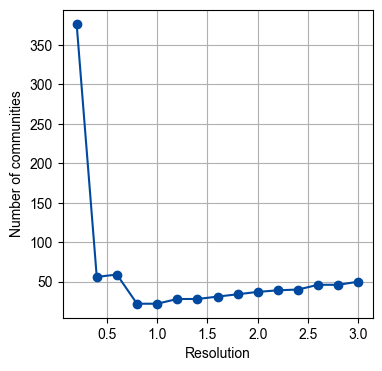

In [24]:
# Subplot 1: Número de comunidades
plt.figure(figsize=(4, 4))
# Type of texts in the plot
plt.rcParams['font.family'] = 'Arial'
#plt.subplot(1, 2, 1)
plt.plot(resolutions, num_communities, marker='o', color='#00499F')
plt.xlabel('Resolution')
plt.ylabel('Number of communities')
#plt.title('Communities vs. Resolution')
#plt.xlabel('Resolución')
#plt.ylabel('Número de comunidades')
#plt.title('Comunidades vs. Resolución')
plt.grid(True)
# Save & show plot
plt.savefig("resolution_vs_communities_hnscc.tiff", dpi=600, bbox_inches='tight')
plt.grid(True)


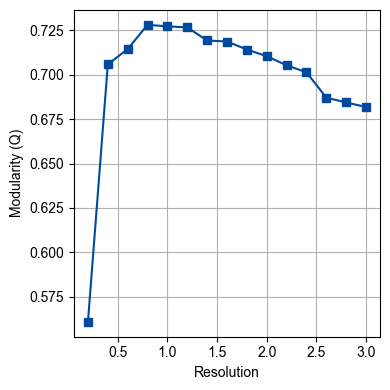

In [25]:

# Subplot 2: Modularidad
plt.figure(figsize=(4, 4))
# Type of texts in the plot
plt.rcParams['font.family'] = 'Arial'
#plt.subplot(1, 2, 2)
plt.plot(resolutions, modularities, marker='s', color='#00499F')
plt.xlabel('Resolution')
plt.ylabel('Modularity (Q)')
#plt.title('Modularity vs. Resolution')
#plt.xlabel('Resolución')
#plt.ylabel('Modularidad (Q)')
#plt.title('Modularidad vs. Resolución')
plt.grid(True)

plt.tight_layout()
# Save & show plot
plt.savefig("resolution_vs_modularity_hnscc.tiff", dpi=600, bbox_inches='tight')
plt.show()


In [26]:
# 1. Detecting communities using the Louvain method
partition = community_louvain.best_partition(G, resolution= 1, random_state=123)

# 2. Adding community information to the graph
nx.set_node_attributes(G, partition, 'community')

# 3. Counting the number of communities detected
num_communities = len(set(partition.values()))
print(f"Number of communities detected: {num_communities}")

# 4. How many nodes are in each community?
# Counting the number of nodes in each community
from collections import Counter
community_count = Counter(partition.values())
print("Size of each community:")
for community, size in community_count.items():
    print(f"  Community {community}: {size} nodos")

Number of communities detected: 22
Size of each community:
  Community 0: 270 nodos
  Community 1: 94 nodos
  Community 2: 249 nodos
  Community 3: 106 nodos
  Community 4: 67 nodos
  Community 5: 109 nodos
  Community 6: 134 nodos
  Community 7: 89 nodos
  Community 8: 227 nodos
  Community 9: 120 nodos
  Community 10: 67 nodos
  Community 11: 91 nodos
  Community 18: 160 nodos
  Community 13: 38 nodos
  Community 14: 17 nodos
  Community 15: 59 nodos
  Community 16: 80 nodos
  Community 17: 129 nodos
  Community 19: 70 nodos
  Community 20: 5 nodos
  Community 21: 5 nodos
  Community 12: 3 nodos


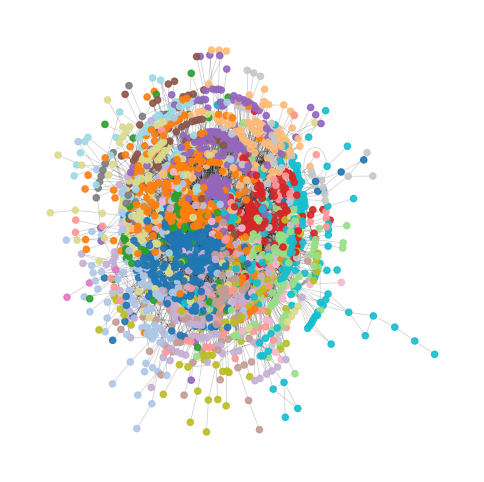

In [27]:
# Assigning colors to communities for visualization
communities = list(set(partition.values()))
color_map = {com: plt.cm.tab20(i % 20) for i, com in enumerate(communities)}
node_colors = [color_map[partition[n]] for n in G.nodes()]

# Visualizing the network with communities
plt.figure(figsize=(6, 6))
pos = nx.kamada_kawai_layout(G)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=20, alpha=0.9)
nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5)
plt.axis('off')
plt.show()


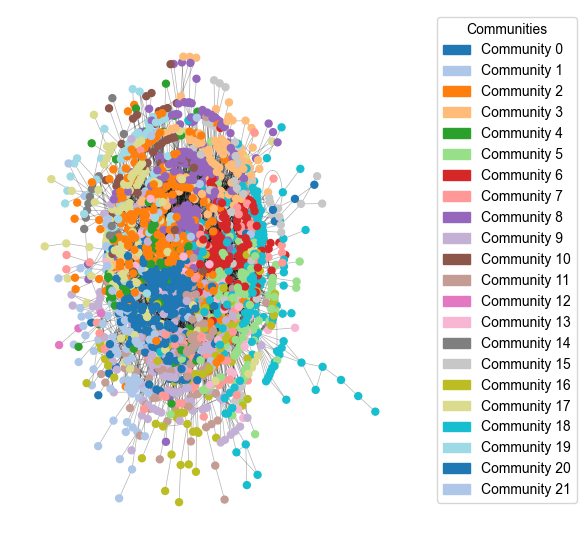

In [28]:
# Visualizing the network with communities with a legend
# Obtaining unique communities
unique_coms = sorted(set(partition.values()))
# Color palette for communities with seaborn
num_coms = len(unique_coms)
#palette = sns.color_palette("Paired", n_colors=num_coms)
palette = sns.color_palette("tab20", n_colors=num_coms)

# Convert the palette to matplotlib format
color_map = [tuple(c) for c in palette]

# Mapping communities to colors
community_to_color = {com: color_map[i] for i, com in enumerate(unique_coms)}

# Coloring nodes based on their community
node_colors = [community_to_color[partition[nodo]] for nodo in G.nodes()]

# Positioning nodes using Kamada-Kawai layout
pos = nx.kamada_kawai_layout(G)

# Drawing the network with communities
# Type of texts in the plot
plt.rcParams['font.family'] = 'Arial'
plt.figure(figsize=(6, 6))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=25, alpha=1.0)
nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.5)
plt.axis('off')

# Creating a legend for communities
legend = [
    #mpatches.Patch(color=community_to_color[com], label=f"Community {com}")
    mpatches.Patch(color=community_to_color[com], label=f"Community {com}")
    for com in unique_coms
]
#plt.legend(handles=legend, title="Communities", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.legend(handles=legend, title="Communities", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
# Save & show plot
plt.savefig("communities_hnscc.tiff", dpi=600, bbox_inches='tight')
plt.show()


In [29]:
# Modularity of the partition
modularity = community_louvain.modularity(partition, G)
print("Modularity:", modularity)

Modularity: 0.7272158700994605


**Analysis of bridge nodes in the global network**

In [30]:
# 1. Betweenness centrality global (sobre todo G)
bet_centrality_global = nx.betweenness_centrality(G)

# 2. Función para calcular Participation Coefficient
def participation_coefficient(G, partition):
    degree_dict = dict(G.degree())
    community_links = defaultdict(lambda: defaultdict(int))
    
    for u, v in G.edges():
        cu = partition[u]
        cv = partition[v]
        community_links[u][cv] += 1
        community_links[v][cu] += 1
    
    p_coeff = {}
    for node in G.nodes():
        ki = degree_dict[node]
        if ki == 0:
            p_coeff[node] = 0
            continue
        sum_sq = 0
        for c, links in community_links[node].items():
            sum_sq += (links / ki) ** 2
        p_coeff[node] = 1 - sum_sq
    return p_coeff

p_coeff_global = participation_coefficient(G, partition)

# 3. Crear DataFrame con las métricas globales
df_bridges = pd.DataFrame({
    'node': list(G.nodes()),
    'community': [partition[n] for n in G.nodes()],
    'betweenness': [bet_centrality_global[n] for n in G.nodes()],
    'participation_coeff': [p_coeff_global[n] for n in G.nodes()]
})

# Round numeric columns to fixed precision for reproducibility
precision = 6
df_bridges['betweenness'] = df_bridges['betweenness'].round(precision)
df_bridges['participation_coeff'] = df_bridges['participation_coeff'].round(precision)

# 4. Definir umbrales (percentil 75 para seleccionar nodos puente)
thresholds = {
    'betweenness': df_bridges['betweenness'].quantile(0.75),
    'participation_coeff': df_bridges['participation_coeff'].quantile(0.75),
}

# 5. Columnas booleanas para nodos con métricas altas
for metric in thresholds:
    df_bridges[f'{metric}_high'] = df_bridges[metric] >= thresholds[metric]

# 6. Definir nodos puente (pueden superar al menos una métrica alta)
df_bridges['bridge_score'] = df_bridges[[f'{m}_high' for m in thresholds]].sum(axis=1)
df_bridges['is_bridge'] = df_bridges['bridge_score'] >= 1

# 7. Para cada nodo puente, identificar comunidades conectadas
def connected_communities(node, G, partition):
    neighbor_coms = set(partition[neighbor] for neighbor in G.neighbors(node))
    return neighbor_coms

df_bridges['connected_communities'] = df_bridges['node'].apply(lambda n: connected_communities(n, G, partition))

# 8. Filtrar solo nodos puente
df_bridges_filtered = df_bridges[df_bridges['is_bridge']].copy()

# 9. Mostrar resumen
print(f"Detected {len(df_bridges_filtered)} bridge nodes:")
print(df_bridges_filtered[['node', 'community', 'betweenness', 'participation_coeff', 'connected_communities']].head(15))

# 10. Guardar resultados en CSV
df_bridges_filtered.to_csv('bridge_nodes_global.csv', index=False)
print("File 'bridge_nodes_global.csv' saved with global bridge nodes and connected communities.")


Detected 845 bridge nodes:
        node  community  betweenness  participation_coeff  \
0        CD4          0     0.114448             0.251540   
1       LCP2          0     0.018044             0.334467   
2       ARF5          1     0.006238             0.000000   
3      ACAP1          1     0.000726             0.375000   
5   TNFRSF1A          2     0.020265             0.586250   
6        GRN          3     0.006145             0.716049   
7      RTN4R          4     0.002212             0.560000   
8       NGFR          4     0.008421             0.544423   
9      TBX21          0     0.005475             0.232742   
10      LAG3          0     0.005410             0.000000   
11    UQCRC1          5     0.007720             0.150400   
12   ATP5F1D          5     0.013675             0.390306   
13      CD74          6     0.028855             0.473829   
14       MIF          0     0.005587             0.750000   
15   SLC25A1          4     0.000840             0.444444 

**Analysis of hubs by community**

In [31]:
# Create a dictionary community -> list of nodes
communities = {}
for node, com in partition.items():
    communities.setdefault(com, []).append(node)

# Make a list of tuples (community, size, nodes)
list_communities = [(com, len(nodes), ','.join(map(str, nodes))) for com, nodes in communities.items()]

# Sort the list of communities by size in descending order
list_communities.sort(key=lambda x: x[1], reverse=True)

# Create a DataFrame with the communities
df_communities = pd.DataFrame(list_communities, columns=['Community', 'Num_Nodes', 'Nodes'])

# Export the DataFrame to a CSV file
df_communities.to_csv('communities_louvain.csv', index=False)
print("File 'communities_louvain.csv' created successfully.")
# Show the first few rows of the DataFrame
df_communities.head() 

File 'communities_louvain.csv' created successfully.


,Community,Num_Nodes,Nodes
0,0,270,"CD4,LCP2,ICAM3,TBX21,LAG3,MIF,IL2RB,GZMH,GZMB,..."
1,2,249,"TNFRSF1A,MAPK13,TAB1,RIPK3,CEBPE,STUB1,PPP2R5B..."
2,8,227,"OTUD5,USP11,BRF2,SNAPC2,KAT2A,MPG,UNG,SIRT2,PA..."
3,18,160,"AMH,MVK,CYP26A1,RBP1,ODC1,ALDH2,ACADS,CIAO3,NU..."
4,6,134,"CD74,HSCB,ACO2,GTPBP1,EXOSC5,FBL,TMEM147,MICAL..."


In [32]:
# Create a dictionary community -> list of nodes
communities = {}
for node, com in partition.items():
    communities.setdefault(com, []).append(node)

# Dictionary to store hubs for each community
hubs_per_community = {}

for com, nodes in communities.items():
    subG = G.subgraph(nodes)

    # Calculate centrality measures for the subgraph    
    degree = nx.degree_centrality(subG)
    betweenness = nx.betweenness_centrality(subG)
    closeness = nx.closeness_centrality(subG)
    eigenvector = nx.eigenvector_centrality(subG, max_iter=1000)
    pagerank = nx.pagerank(subG)

    # Create a DataFrame to store the centrality measures
    df = pd.DataFrame({
        'Node': list(subG.nodes()),
        'DegreeCentrality': [degree[n] for n in subG.nodes()],
        'BetweennessCentrality': [betweenness[n] for n in subG.nodes()],
        'ClosenessCentrality': [closeness[n] for n in subG.nodes()],
        'EigenvectorCentrality': [eigenvector[n] for n in subG.nodes()],
        'PageRank': [pagerank[n] for n in subG.nodes()]
    })

    # Sort the DataFrame by DegreeCentrality and BetweennessCentrality
    df = df.sort_values(by=['DegreeCentrality', 'BetweennessCentrality'], ascending=False)

    # Save hubs for the community
    #hubs_por_comunidad[com] = df.head(10)
    hubs_per_community[com] = df

    # Export the DataFrame to a CSV file for each community
    df.to_csv(f"hubs_community_{com}.csv", index=False)
    print(f"Hubs calculated and saved for community {com}")


Hubs calculated and saved for community 0
Hubs calculated and saved for community 1
Hubs calculated and saved for community 2
Hubs calculated and saved for community 3
Hubs calculated and saved for community 4
Hubs calculated and saved for community 5
Hubs calculated and saved for community 6
Hubs calculated and saved for community 7
Hubs calculated and saved for community 8
Hubs calculated and saved for community 9
Hubs calculated and saved for community 10
Hubs calculated and saved for community 11
Hubs calculated and saved for community 18
Hubs calculated and saved for community 13
Hubs calculated and saved for community 14
Hubs calculated and saved for community 15
Hubs calculated and saved for community 16
Hubs calculated and saved for community 17
Hubs calculated and saved for community 19
Hubs calculated and saved for community 20
Hubs calculated and saved for community 21
Hubs calculated and saved for community 12


In [33]:
# Displaying the number of hubs detected in each community
print("\nDetecting hubs by combined criteria (≥3 metrics ≥ 75th percentile))...")

precision = 6  # Fix precision for stability
for com, df in hubs_per_community.items():
    # Round all centrality values to fix precision before percentile calculation
    for metric in ['DegreeCentrality', 'BetweennessCentrality', 'ClosenessCentrality', 'EigenvectorCentrality', 'PageRank']:
        df[metric] = df[metric].round(precision)

    # Calculating the 75th percentile thresholds for each metric
    thresholds = {
        'DegreeCentrality': df['DegreeCentrality'].quantile(0.75),
        'BetweennessCentrality': df['BetweennessCentrality'].quantile(0.75),
        'ClosenessCentrality': df['ClosenessCentrality'].quantile(0.75),
        'EigenvectorCentrality': df['EigenvectorCentrality'].quantile(0.75),
        'PageRank': df['PageRank'].quantile(0.75),
    }

    # Adding boolean columns for each metric indicating if the node exceeds the threshold
    for metric in thresholds:
        df[f'{metric}_High'] = df[metric] >= thresholds[metric]

    # Calculating the hub score as the sum of boolean columns
    # A node is considered a hub if it exceeds at least 3 of the thresholds
    df['HubScore'] = df[[f'{m}_High' for m in thresholds]].sum(axis=1)

    # Determining if a node is a hub based on the HubScore
    # A node is a hub if its HubScore is 3 or more
    df['IsHub'] = df['HubScore'] >= 3

    # Adding the community information to the DataFrame
    # This will help in identifying which community the hubs belong to
    df['Community'] = com

    print(f"  Community {com}: {df['IsHub'].sum()} hubs detected")

# Concatenating all DataFrames into a single DataFrame
df_all = pd.concat(hubs_per_community.values(), ignore_index=True)

# Filtering the DataFrame to keep only the hubs
df_hubs_final = df_all[df_all['IsHub'] == True]

# Guardar archivo con trazabilidad de métricas
df_hubs_final.to_csv('filtered_hubs_by_criteria.csv', index=False)
print("\nFile 'filtered_hubs_by_criteria.csv' created successfully with hubs filtered by criteria.")
df_hubs_final.head()  # Mostrar las primeras filas del DataFrame filtrado


Detecting hubs by combined criteria (≥3 metrics ≥ 75th percentile))...
  Community 0: 72 hubs detected
  Community 1: 26 hubs detected
  Community 2: 63 hubs detected
  Community 3: 27 hubs detected
  Community 4: 14 hubs detected
  Community 5: 23 hubs detected
  Community 6: 33 hubs detected
  Community 7: 22 hubs detected
  Community 8: 62 hubs detected
  Community 9: 30 hubs detected
  Community 10: 19 hubs detected
  Community 11: 22 hubs detected
  Community 18: 44 hubs detected
  Community 13: 11 hubs detected
  Community 14: 8 hubs detected
  Community 15: 15 hubs detected
  Community 16: 21 hubs detected
  Community 17: 32 hubs detected
  Community 19: 19 hubs detected
  Community 20: 3 hubs detected
  Community 21: 3 hubs detected
  Community 12: 1 hubs detected

File 'filtered_hubs_by_criteria.csv' created successfully with hubs filtered by criteria.


,Node,DegreeCentrality,BetweennessCentrality,ClosenessCentrality,EigenvectorCentrality,PageRank,DegreeCentrality_High,BetweennessCentrality_High,ClosenessCentrality_High,EigenvectorCentrality_High,PageRank_High,HubScore,IsHub,Community
0,CD4,0.446097,0.391475,0.587336,0.365614,0.048084,True,True,True,True,True,5,True,0
1,CCR7,0.234201,0.064676,0.471930,0.263560,0.022451,True,True,True,True,True,5,True,0
2,CD27,0.200743,0.059949,0.474427,0.224773,0.020400,True,True,True,True,True,5,True,0
3,GZMB,0.163569,0.026218,0.459044,0.217560,0.015554,True,True,True,True,True,5,True,0
4,TYROBP,0.159851,0.111081,0.419657,0.075251,0.022899,True,True,True,True,True,5,True,0


In [34]:
# Create a dictionary community -> list of nodes
communities = {}
for node, com in partition.items():
    communities.setdefault(com, []).append(node)

# Dictionary to store hubs for each community
hubs_per_community = {}

for com, nodes in communities.items():
    subG = G.subgraph(nodes)

    # Calculate centrality measures for the subgraph    
    degree = nx.degree_centrality(subG)
    betweenness = nx.betweenness_centrality(subG)
    closeness = nx.closeness_centrality(subG)
    eigenvector = nx.eigenvector_centrality(subG, max_iter=1000)
    pagerank = nx.pagerank(subG)

    # Create a DataFrame to store the centrality measures
    df = pd.DataFrame({
        'Node': list(subG.nodes()),
        'DegreeCentrality': [degree[n] for n in subG.nodes()],
        'BetweennessCentrality': [betweenness[n] for n in subG.nodes()],
        'ClosenessCentrality': [closeness[n] for n in subG.nodes()],
        'EigenvectorCentrality': [eigenvector[n] for n in subG.nodes()],
        'PageRank': [pagerank[n] for n in subG.nodes()]
    })

    # Sort the DataFrame by DegreeCentrality and BetweennessCentrality
    df = df.sort_values(by=['DegreeCentrality', 'BetweennessCentrality'], ascending=False)

    # Save hubs for the community
    #hubs_por_comunidad[com] = df.head(10)
    hubs_per_community[com] = df

    # Export the DataFrame to a CSV file for each community
    df.to_csv(f"hubs_community_{com}.csv", index=False)
    print(f"Hubs calculated and saved for community {com}")


Hubs calculated and saved for community 0
Hubs calculated and saved for community 1
Hubs calculated and saved for community 2
Hubs calculated and saved for community 3
Hubs calculated and saved for community 4
Hubs calculated and saved for community 5
Hubs calculated and saved for community 6
Hubs calculated and saved for community 7
Hubs calculated and saved for community 8
Hubs calculated and saved for community 9
Hubs calculated and saved for community 10
Hubs calculated and saved for community 11
Hubs calculated and saved for community 18
Hubs calculated and saved for community 13
Hubs calculated and saved for community 14
Hubs calculated and saved for community 15
Hubs calculated and saved for community 16
Hubs calculated and saved for community 17
Hubs calculated and saved for community 19
Hubs calculated and saved for community 20
Hubs calculated and saved for community 21
Hubs calculated and saved for community 12


In [35]:
# Displaying the shape of the final hubs DataFrame
print("\nShape of the final hubs DataFrame:")
df_hubs_final.shape  


Shape of the final hubs DataFrame:


(570, 14)

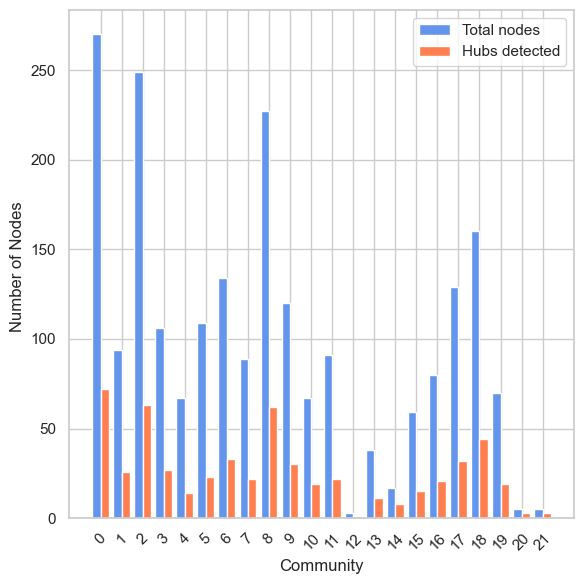

In [36]:
# Total number of hubs detected per community
list_nodes = [(node, com) for com, nodes in communities.items() for node in nodes]
df_total = pd.DataFrame(list_nodes, columns=['Node', 'Community'])
total_per_community = df_total['Community'].value_counts().sort_index()

# Total number of nodes per community
hubs_per_community_count = df_all[df_all['IsHub'] == True]['Community'].value_counts().sort_index()

# Creating a DataFrame for plotting
df_plot = pd.DataFrame({
    'Total_nodes': total_per_community,
    'Hubs_detected': hubs_per_community_count
}).fillna(0).astype(int).reset_index().rename(columns={'index': 'Community'})

# Plotting the total nodes vs detected hubs per community
plt.figure(figsize=(6, 6))
sns.set(style="whitegrid")
bar_width = 0.4
x = range(len(df_plot))
plt.bar([i - bar_width/2 for i in x], df_plot['Total_nodes'], width=bar_width, label='Total nodes', color='cornflowerblue')
plt.bar([i + bar_width/2 for i in x], df_plot['Hubs_detected'], width=bar_width, label='Hubs detected', color='coral')
plt.xticks(ticks=x, labels=df_plot['Community'], rotation=45)
plt.ylabel('Number of Nodes ')
plt.xlabel('Community')
plt.legend()
plt.tight_layout()
plt.show()

Here, the hubs detected by community are taken, as they represent our potential genes for study.

In [37]:
# Load the hubs DataFrame (make sure the column with node names is called 'Node')
hubs = pd.read_csv("filtered_hubs_by_criteria.csv")

# Extract the list of hubs and check if they are in the network G
hubs_nodes = [node for node in hubs['Node'] if node in G.nodes()]
print(f"Number of hubs found in network: {len(hubs_nodes)}")

# Extracting the metrics for the hubs
hubs_metrics = centralities_df.loc[hubs_nodes]

print("Metrics for hubs:")
print(hubs_metrics.describe())

Number of hubs found in network: 570
Metrics for hubs:
           degree  betweenness   closeness   eigenvector  clustering_coeff  \
count  570.000000   570.000000  570.000000  5.700000e+02        570.000000   
mean     0.005891     0.005471    0.227289  1.650595e-02          0.197462   
std      0.006146     0.016845    0.031900  3.556798e-02          0.180374   
min      0.000914     0.000000    0.117628  4.531774e-09          0.000000   
25%      0.002742     0.000915    0.203549  3.723639e-04          0.062454   
50%      0.004113     0.002327    0.224502  2.107096e-03          0.165751   
75%      0.006856     0.005820    0.252590  1.341570e-02          0.295345   
max      0.079068     0.354186    0.349186  3.675195e-01          1.000000   

       neighborhood_connectivity    PageRank  
count                 570.000000  570.000000  
mean                   16.167957    0.000992  
std                    13.756865    0.000871  
min                     1.500000    0.000224  
25%    

**Analysis of random permutations:**

Are the hubs we have selected really hubs? What happens if we remove them? Does the network retain its dynamics and structure? We address these questions through analysis of random network permutations.

Random nodes degree mean (avg over 10000 runs): 0.0024 ± 0.0001
Random nodes betweenness mean (avg over 10000 runs): 0.0018 ± 0.0003


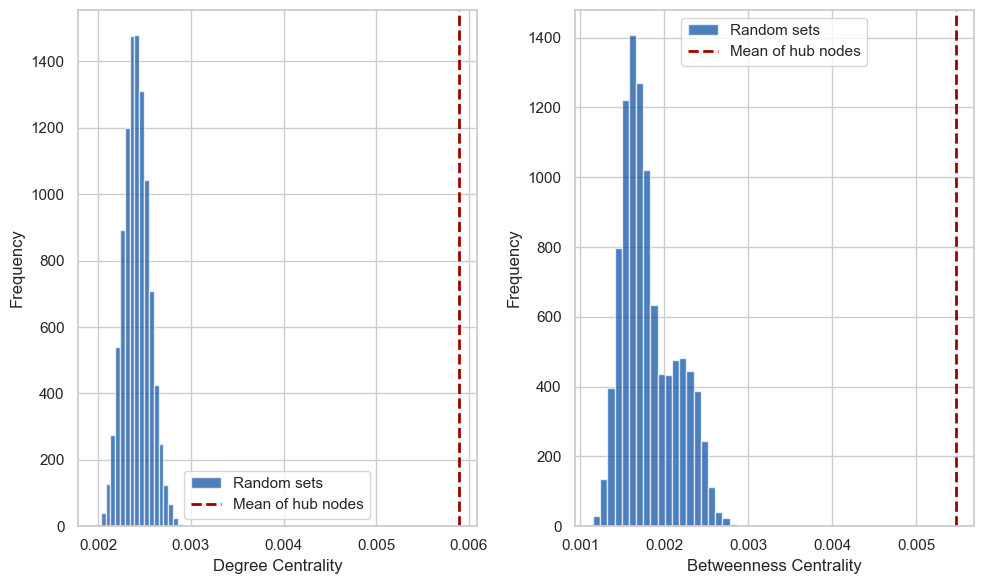

Mann-Whitney U test for degree centrality: p = 9.0735e-105
Mann-Whitney U test for betweenness centrality: p = 1.2212e-11
Mean degree of hubs: 0.0059
Mean betweenness of hubs: 0.0055


In [41]:
# Analysis of hubs vs random nodes
# Generating random nodes for comparison
num_random = 10000  # number of random sets to generate
random_means_degree = []
random_means_betweenness = []

all_nodes = list(G.nodes())
num_hubs = len(hubs_nodes)

# Generating random sets of nodes and calculating their degree and betweenness centrality means
# Setting a random seed for reproducibility
np.random.seed(42)  
for i in range(num_random):
    random_nodes = np.random.choice(all_nodes, size=num_hubs, replace=False)
    random_degree_mean = centralities_df.loc[random_nodes]['degree'].mean()
    random_betweenness_mean = centralities_df.loc[random_nodes]['betweenness'].mean()
    random_means_degree.append(random_degree_mean)
    random_means_betweenness.append(random_betweenness_mean)

print(f"Random nodes degree mean (avg over {num_random} runs): {np.mean(random_means_degree):.4f} ± {np.std(random_means_degree):.4f}")
print(f"Random nodes betweenness mean (avg over {num_random} runs): {np.mean(random_means_betweenness):.4f} ± {np.std(random_means_betweenness):.4f}")

# Plotting the distribution of random means and comparing with hubs metrics
plt.figure(figsize=(10, 6))
# Type of texts in the plot
plt.rcParams['font.family'] = 'Arial'
plt.subplot(1, 2, 1)
plt.hist(random_means_degree, bins=20, alpha=0.7, label="Random sets", color='#00499F')
plt.axvline(hubs_metrics['degree'].mean(), color='#9F0000', linestyle='dashed', linewidth=2, label="Mean of hub nodes")
#plt.title("Centralidad de grado")
plt.xlabel("Degree Centrality")
plt.ylabel("Frequency")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(random_means_betweenness, bins=20, alpha=0.7, label="Random sets", color='#00499F')
plt.axvline(hubs_metrics['betweenness'].mean(), color='#9F0000', linestyle='dashed', linewidth=2, label="Mean of hub nodes")
#plt.title("Centralidad de intermediación")
plt.xlabel("Betweenness Centrality")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
# Save & show plot
plt.savefig("random_networks_hnscc_centrality.tiff", dpi=600, bbox_inches='tight')
plt.show()

# Performing the Mann-Whitney U test to compare hubs metrics with random means
u_stat_degree, p_val_degree = mannwhitneyu(hubs_metrics['degree'], random_means_degree)
u_stat_betw, p_val_betw = mannwhitneyu(hubs_metrics['betweenness'], random_means_betweenness)

print(f"Mann-Whitney U test for degree centrality: p = {p_val_degree:.4e}")
print(f"Mann-Whitney U test for betweenness centrality: p = {p_val_betw:.4e}")
print(f"Mean degree of hubs: {hubs_metrics['degree'].mean():.4f}")
print(f"Mean betweenness of hubs: {hubs_metrics['betweenness'].mean():.4f}")


Random nodes degree mean (avg over 10000 runs): 0.0024 ± 0.0001
Random nodes betweenness mean (avg over 10000 runs): 0.0018 ± 0.0003


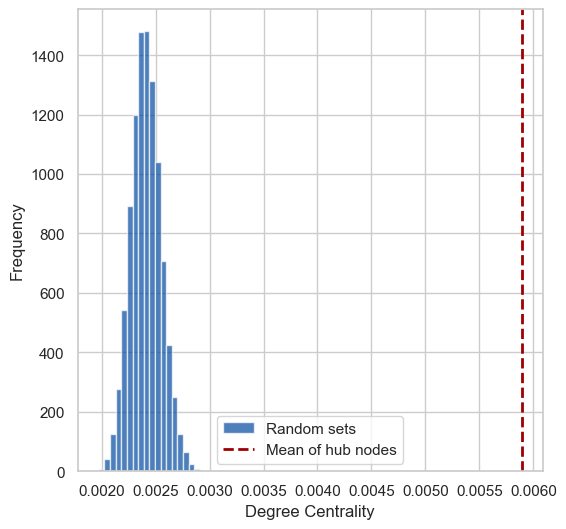

In [42]:
# Analysis of hubs vs random nodes
# Generating random nodes for comparison
num_random = 10000  # number of random sets to generate
random_means_degree = []
random_means_betweenness = []

all_nodes = list(G.nodes())
num_hubs = len(hubs_nodes)

# Generating random sets of nodes and calculating their degree and betweenness centrality means
# Setting a random seed for reproducibility
np.random.seed(42)  
for i in range(num_random):
    random_nodes = np.random.choice(all_nodes, size=num_hubs, replace=False)
    random_degree_mean = centralities_df.loc[random_nodes]['degree'].mean()
    random_betweenness_mean = centralities_df.loc[random_nodes]['betweenness'].mean()
    random_means_degree.append(random_degree_mean)
    random_means_betweenness.append(random_betweenness_mean)

print(f"Random nodes degree mean (avg over {num_random} runs): {np.mean(random_means_degree):.4f} ± {np.std(random_means_degree):.4f}")
print(f"Random nodes betweenness mean (avg over {num_random} runs): {np.mean(random_means_betweenness):.4f} ± {np.std(random_means_betweenness):.4f}")

# Plotting the distribution of random means and comparing with hubs metrics
plt.figure(figsize=(6, 6))
# Type of texts in the plot
plt.rcParams['font.family'] = 'Arial'
#plt.subplot(1, 2, 1)
plt.hist(random_means_degree, bins=20, alpha=0.7, label="Random sets", color='#00499F')
plt.axvline(hubs_metrics['degree'].mean(), color='#9F0000', linestyle='dashed', 
            linewidth=2, label="Mean of hub nodes")
#plt.title("Centralidad de grado")
plt.xlabel("Degree Centrality")
plt.ylabel("Frequency")
plt.legend()
# Save & show plot
plt.savefig("random_networks_hncss_centrality_degree.tiff", dpi=600, bbox_inches='tight')


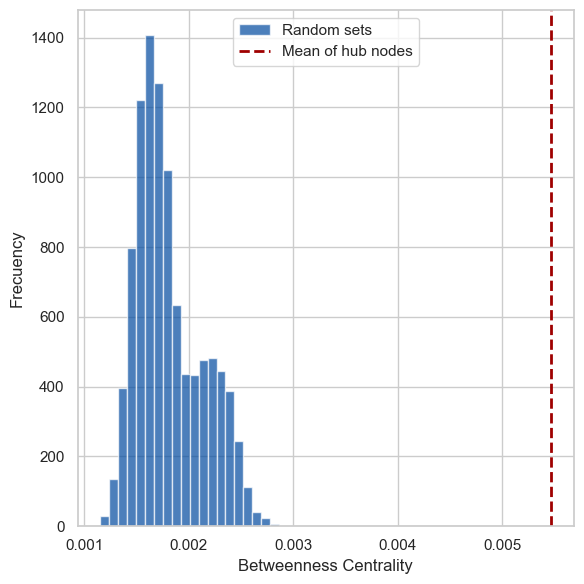

Mann-Whitney U test for degree centrality: p = 9.0735e-105
Mann-Whitney U test for betweenness centrality: p = 1.2212e-11


In [43]:

#plt.subplot(1, 2, 2)
plt.figure(figsize=(6, 6))
# Type of texts in the plot
plt.rcParams['font.family'] = 'Arial'
plt.hist(random_means_betweenness, bins=20, alpha=0.7, label="Random sets", color='#00499F')
plt.axvline(hubs_metrics['betweenness'].mean(), color='#9F0000', linestyle='dashed', 
            linewidth=2, label="Mean of hub nodes")
#plt.title("Centralidad de intermediación")
plt.xlabel("Betweenness Centrality")
plt.ylabel("Frecuency")
plt.legend()

plt.tight_layout()
# Save & show plot
plt.savefig("random_networks_hncss_centrality_betweenness.tiff", dpi=600, bbox_inches='tight')
plt.show()

# Performing the Mann-Whitney U test to compare hubs metrics with random means
u_stat_degree, p_val_degree = mannwhitneyu(hubs_metrics['degree'], random_means_degree)
u_stat_betw, p_val_betw = mannwhitneyu(hubs_metrics['betweenness'], random_means_betweenness)

print(f"Mann-Whitney U test for degree centrality: p = {p_val_degree:.4e}")
print(f"Mann-Whitney U test for betweenness centrality: p = {p_val_betw:.4e}")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


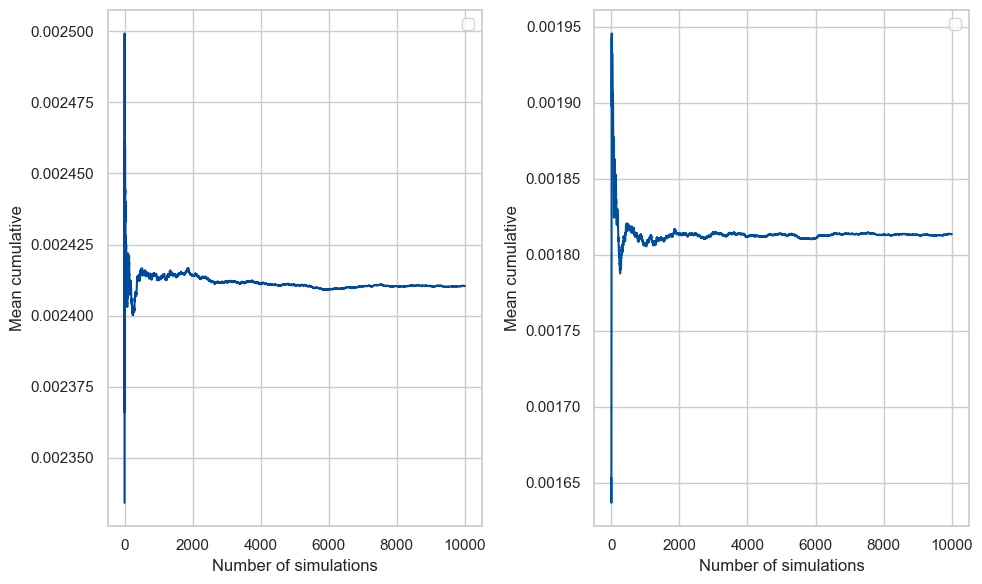

Degree Centrality converges after 10000 simulations
Betweenness Centrality converges after 10000 simulations


In [44]:
# Function to calculate cumulative means
def cumulative_means(data):
    return np.cumsum(data) / np.arange(1, len(data) + 1)

# Calculating cumulative means for random sets
mean_acum_degree = cumulative_means(random_means_degree)
mean_acum_betweenness = cumulative_means(random_means_betweenness)

# Calculating cumulative means for hubs metrics convergence
def convergence(mean_acum, threshold=1e-5, window=10000):
    """
    Detects the point where the cumulative average stabilises.

    Parameters:
        cumulative_average (list or np.array): Series of cumulative averages.
        threshold (float): Minimum change considered stable.
        window (int): Number of points to calculate average change.

    Returns:
        int: Index where the average is considered stable.
    """
    mean_acum = np.array(mean_acum)
    changes = np.abs(np.diff(mean_acum))

    for i in range(window, len(changes)):
        mean_changes = np.mean(changes[i - window:i])
        if mean_changes < threshold:
            return i  # convergence point found
    return len(mean_acum)  # no convergence found

# Finding convergence points for cumulative means
convergence_degree = convergence(mean_acum_degree)
convergence_betweenness = convergence(mean_acum_betweenness)

# Plotting the cumulative means and convergence points
plt.figure(figsize=(10, 6))
# Type of texts in the plot
plt.rcParams['font.family'] = 'Arial'

plt.subplot(1, 2, 1)
#plt.plot(mean_acum_degree, label='Media acumulada de la centralidad de grado', color='#00499F')
plt.plot(mean_acum_degree, color='#00499F')
#plt.axvline(convergence_degree, color='#9F0000', linestyle='--', label=f'Convergence at {convergence_degree}')
plt.xlabel('Number of simulations')
plt.ylabel('Mean cumulative')
#plt.title('Cumulative Mean of Degree Centrality')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
#plt.plot(mean_acum_betweenness, label='Cumulative mean Betweenness Centrality', color='darkorange')
plt.plot(mean_acum_betweenness, color='#004F9F')
#plt.axvline(convergence_betweenness, color='green', linestyle='--', label=f'Convergence at {convergence_betweenness}')
plt.xlabel('Number of simulations')
plt.ylabel('Mean cumulative')
#plt.title('Cumulative Mean of Betweenness Centrality')
plt.grid(True)
plt.legend()

plt.tight_layout()
# Save & show plot
plt.savefig("random_network_hncss_cumulative_mean_centralities.tiff", dpi=600, bbox_inches='tight')
plt.show()

print(f"Degree Centrality converges after {convergence_degree} simulations")
print(f"Betweenness Centrality converges after {convergence_betweenness} simulations")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


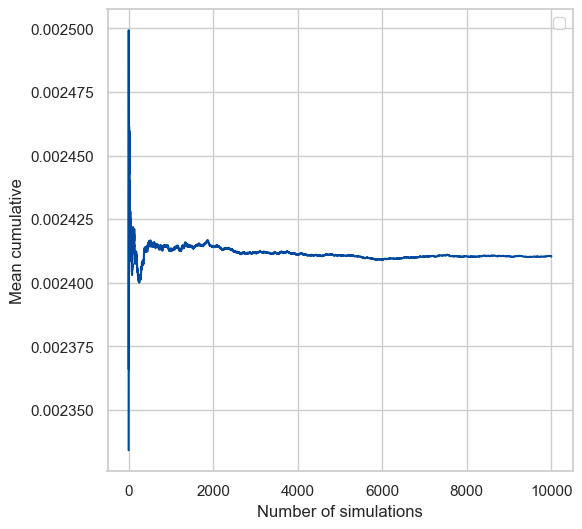

In [45]:
# Plotting the cumulative means and convergence points
plt.figure(figsize=(6, 6))
# Type of texts in the plot
plt.rcParams['font.family'] = 'Arial'
#plt.subplot(1, 2, 1)
#plt.plot(mean_acum_degree, label='Media acumulada de la centralidad de grado', color='#00499F')
plt.plot(mean_acum_degree, color='#00499F')
#plt.axvline(convergence_degree, color='#9F0000', linestyle='--', label=f'Convergence at {convergence_degree}')
plt.xlabel('Number of simulations')
plt.ylabel('Mean cumulative')
#plt.title('Cumulative Mean of Degree Centrality')
plt.grid(True)
plt.legend()
# Save & show plot
plt.savefig("random_network_hncss_cumulative_mean_degree.tiff", dpi=600, bbox_inches='tight')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


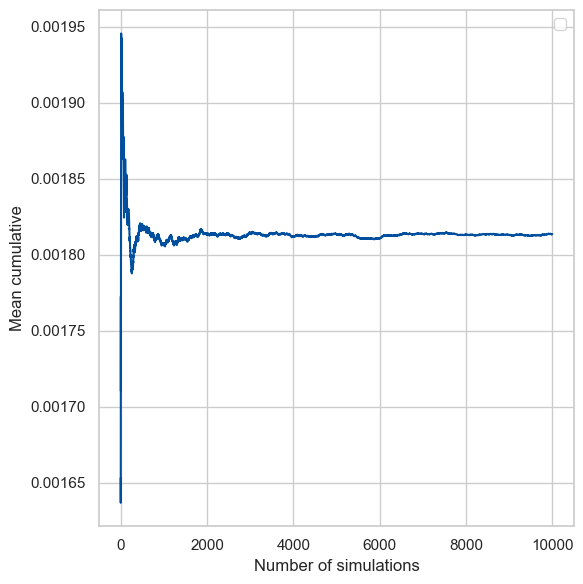

Degree Centrality converges after 10000 simulations
Betweenness Centrality converges after 10000 simulations


In [46]:
# Plotting the cumulative means and convergence points
plt.figure(figsize=(6, 6))
# Type of texts in the plot
plt.rcParams['font.family'] = 'Arial'
#plt.subplot(1, 2, 2)
#plt.plot(mean_acum_betweenness, label='Cumulative mean Betweenness Centrality', color='darkorange')
plt.plot(mean_acum_betweenness, color='#004F9F')
#plt.axvline(convergence_betweenness, color='green', linestyle='--', label=f'Convergence at {convergence_betweenness}')
plt.xlabel('Number of simulations')
plt.ylabel('Mean cumulative')
#plt.title('Cumulative Mean of Betweenness Centrality')
plt.grid(True)
plt.legend()

plt.tight_layout()
# Save & show plot
plt.savefig("random_network_hncss_cumulative_mean_betweenness.tiff", dpi=600, bbox_inches='tight')
plt.show()

print(f"Degree Centrality converges after {convergence_degree} simulations")
print(f"Betweenness Centrality converges after {convergence_betweenness} simulations")

Size of the largest component after removing hubs: 83
Average size of the largest component when removing random nodes: 1425.97 ± 25.75


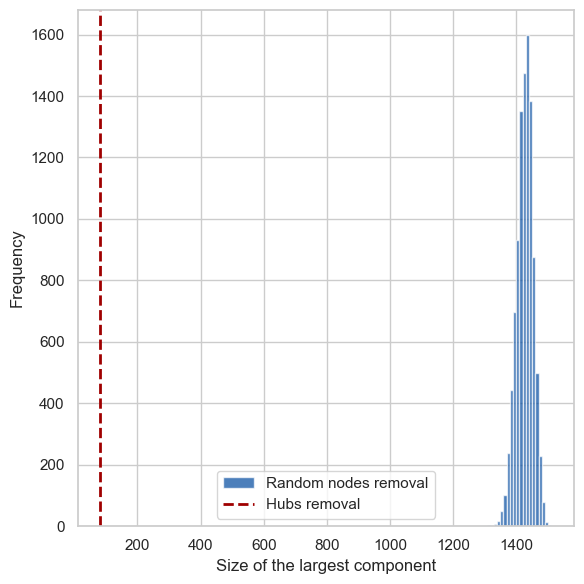

In [47]:
# Calculating the size of the largest component after removing hubs
G_copy = G.copy()
G_copy.remove_nodes_from(hubs_nodes)

if len(G_copy) == 0:
    largest_cc_size = 0
else:
    largest_cc = max(nx.connected_components(G_copy), key=len)
    largest_cc_size = len(largest_cc)

print(f"Size of the largest component after removing hubs: {largest_cc_size}")

# Setting a random seed for reproducibility
np.random.seed(42) 
# Calculating the size of the largest component after removing random nodes
num_iter = 10000
random_sizes = []

for _ in range(num_iter):
    random_nodes = np.random.choice(list(G.nodes()), size=len(hubs_nodes), replace=False)
    G_temp = G.copy()
    G_temp.remove_nodes_from(random_nodes)
    if len(G_temp) == 0:
        random_sizes.append(0)
    else:
        largest_cc = max(nx.connected_components(G_temp), key=len)
        random_sizes.append(len(largest_cc))

print(f"Average size of the largest component when removing random nodes: {np.mean(random_sizes):.2f} ± {np.std(random_sizes):.2f}")

# Plotting the distribution of the size of the largest component after removing hubs vs random nodes
plt.figure(figsize=(6, 6))
# Type of texts in the plot
plt.rcParams['font.family'] = 'Arial'
plt.hist(random_sizes, bins=20, alpha=0.7, label="Random nodes removal", color='#00499F')
plt.axvline(largest_cc_size, color='#9F0000', linestyle='--', linewidth=2, label="Hubs removal")
plt.xlabel("Size of the largest component")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
# Save & show plot
plt.savefig("random_network_hncss_elimination_hubs.tiff", dpi=600, bbox_inches='tight')
plt.show()


In [48]:
# Observed largest component after removing hubs
obs_largest_cc = largest_cc_size  # 699

# random_sizes ya contiene 10,000 simulaciones aleatorias
random_sizes_array = np.array(random_sizes)

# p-value: proporción de simulaciones con componente menor o igual a la observada
p_value = np.sum(random_sizes_array <= obs_largest_cc) / len(random_sizes_array)
print(f"P-value (permutation test): {p_value:.4e}")


P-value (permutation test): 0.0000e+00


Convergence of variance at iteration: 9999


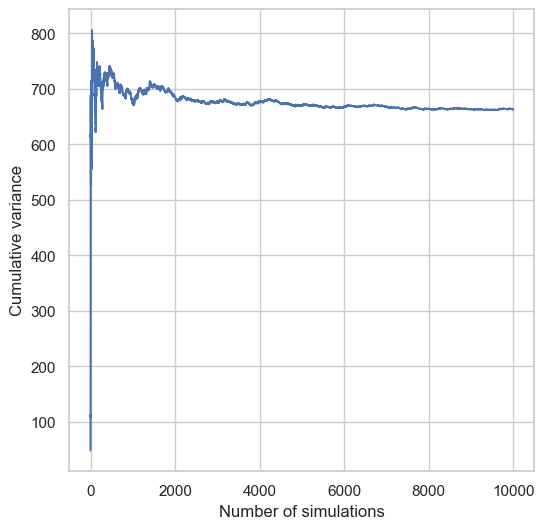

In [49]:
# Function to calculate the accumulated variance of a list of data
def variance_acum(data):
    var_acum = [np.var(data[:i]) for i in range(2, len(data) + 1)]
    return np.array(var_acum)

def convergence_var(var_acum, threshold=1e-5, window=100):#, min_consec=5):
    change = np.abs(np.diff(var_acum))
    for i in range(window, len(change)):
        mean_change = np.mean(change[i - window:i])
        if mean_change < threshold:
            return i
    return len(var_acum)

# Setting a random seed for reproducibility
np.random.seed(42)

# Calculating the size of the largest component after removing hubs
# Setting a random seed for reproducibility
num_iter = 10000
random_sizes = []

for _ in range(num_iter):
    random_nodes = np.random.choice(list(G.nodes()), size=len(hubs_nodes), replace=False)
    G_temp = G.copy()
    G_temp.remove_nodes_from(random_nodes)
    if len(G_temp) == 0:
        random_sizes.append(0)
    else:
        largest_cc = max(nx.connected_components(G_temp), key=len)
        random_sizes.append(len(largest_cc))

var_acum = variance_acum(random_sizes)
convergence = convergence_var(var_acum)

print(f"Convergence of variance at iteration: {convergence}")

# Plotting the accumulated variance
plt.figure(figsize=(6,6))
# Type of texts in the plot
plt.rcParams['font.family'] = 'Arial'
plt.plot(var_acum)
plt.xlabel('Number of simulations')
plt.ylabel('Cumulative variance')
#plt.title('Convergence of variance over simulations')
#plt.legend()
# Save & show plot
plt.savefig("random_network_hnscc_cumulative_variance.tiff", dpi=600, bbox_inches='tight')
plt.show()

Here, a graph is generated with the nodes of interest (hubs) to visualise them more clearly with Cytoscape.

In [50]:
# Creating a subgraph with the hubs
subgraph_hubs = G.subgraph(hubs_nodes).copy()

# Exporting the subgraph of hubs to CSV files
edges_df = nx.to_pandas_edgelist(subgraph_hubs)
edges_df.to_csv("hubs_network_edges.csv", index=False)

# Exporting the nodes of the subgraph of hubs to a CSV file
nodes_df = pd.DataFrame({"id": list(subgraph_hubs.nodes())})
nodes_df.to_csv("hubs_network_nodes.csv", index=False)

print("Subgraph of hubs exported as 'hubs_network_edges.csv' and 'hubs_network_nodes.csv'")

Subgraph of hubs exported as 'hubs_network_edges.csv' and 'hubs_network_nodes.csv'


In [51]:
# Identify disconnected components among hubs

# Detect connected components in the hub-only subgraph
components = list(nx.connected_components(subgraph_hubs))

# Map each hub node to its component ID
component_map = {}
for idx, comp in enumerate(components):
    for node in comp:
        component_map[node] = idx

# Select bridge nodes that connect multiple hub components
# Filter bridge nodes that connect hubs across different components
bridge_connectors = []

for _, row in df_bridges[df_bridges['is_bridge']].iterrows():
    node = row['node']
    neighbors = list(G.neighbors(node))
    
    # Determine which hub components this node connects to
    neighbor_components = {component_map[n] for n in neighbors if n in component_map}
    
    # Keep node if it connects at least two hub components
    if len(neighbor_components) >= 2:
        bridge_connectors.append(node)

# Select bridge nodes with high participation coefficient (75th percentile)
# Threshold for high participation (can be adjusted)
participation_cutoff = df_bridges['participation_coeff'].quantile(0.75)

# Select bridges with high participation
high_participation_bridges = df_bridges[
    (df_bridges['is_bridge']) & 
    (df_bridges['participation_coeff'] >= participation_cutoff)
]['node'].tolist()


# Build the extended subgraph: hubs + important bridges
# Combine all relevant nodes
final_nodes = set(subgraph_hubs.nodes()) | set(bridge_connectors) | set(high_participation_bridges)

# Create the extended subgraph
subgraph_extended = G.subgraph(final_nodes).copy()

# Export the extended subgraph
# Export edges of the extended subgraph to CSV
edges_ext = nx.to_pandas_edgelist(subgraph_extended)
edges_ext.to_csv("extended_hub_bridge_network_edges.csv", index=False)

# Label node types (hub / bridge_connector / bridge_participant)
nodes_ext = pd.DataFrame({
    "id": list(subgraph_extended.nodes()),
    "type": [
        "hub" if n in subgraph_hubs.nodes()
        else "bridge_connector" if n in bridge_connectors
        else "bridge_participant"
        for n in subgraph_extended.nodes()
    ]
})
nodes_ext.to_csv("extended_hub_bridge_network_nodes.csv", index=False)

print("Extended subgraph exported as 'extended_hub_bridge_network_edges.csv' and 'extended_hub_bridge_network_nodes.csv'")


Extended subgraph exported as 'extended_hub_bridge_network_edges.csv' and 'extended_hub_bridge_network_nodes.csv'


**Enrichment Analysis:**

In [39]:
# Installing GSEApy for gene set enrichment analysis
#!pip install gseapy

In [52]:
# Importing GSEApy for gene set enrichment analysis
import gseapy as gp

In [53]:
# Reading the communities DataFrame
# This DataFrame should contain the community IDs and the nodes (genes) in each community
enrichment_results = {}

for idx, row in df_communities.iterrows():
    community_id = row['Community']
    genes_str = row['Nodes']
    genes_list = genes_str.split(',')

    # Enrichr GO Biological Process 2021 (puedes cambiar el gene_sets)
    enr = gp.enrichr(
        gene_list=genes_list,
        gene_sets=['GO_Biological_Process_2021'],
        outdir=None,  # No output directory, results will be returned as a DataFrame
        cutoff=0.05   # Significance level for enrichment
    )
    
    # Store results in the enrichment_results dictionary
    # If results are empty, store an empty DataFrame
    if not enr.results.empty:
        enrichment_results[community_id] = enr.results
    else:
        enrichment_results[community_id] = pd.DataFrame()

# Displaying the enrichment results for each community
#print(enrichment_results[9].head())

# Exporting the enrichment results for each community to CSV files
for com, df in enrichment_results.items():
    if not df.empty:
        df.to_csv(f"enrichment_community_{com}.csv", index=False)


In [54]:
# Overlap of GO terms per community
# Create a dictionary to store the top GO term for each community
top_terms = {}

for com, df in enrichment_results.items():
    if not df.empty:
        # Sort the DataFrame by Adjusted P-value and Overlap
        df['Overlap_num'] = df['Overlap'].apply(lambda x: int(x.split('/')[0]))
        top_term = df.sort_values(by='Overlap_num', ascending=False).iloc[0]
        top_terms[com] = top_term[['Term', 'Overlap', 'Adjusted P-value']]
    else:
        top_terms[com] = None

# Displaying the top GO term for each community
for com, term_info in top_terms.items():
    print(f"Community {com}:")
    if term_info is not None:
        print(f"  Top GO term: {term_info['Term']}")
        print(f"  Overlap: {term_info['Overlap']}")
        print(f"  Adjusted p-value: {term_info['Adjusted P-value']:.2e}\n")
    else:
        print("  No enriched terms found.\n")
# Saving the top GO terms for each community to a DataFrame
# This DataFrame will contain the community ID, top GO term, overlap, and adjusted p-value
top_terms_df = pd.DataFrame.from_dict(top_terms, orient='index').reset_index()
top_terms_df.columns = ['Community', 'Top GO Term', 'Overlap', 'Adjusted P-value']
# Removing rows with NaN values
top_terms_df = top_terms_df.dropna()
# Showing the first few rows of the DataFrame
top_terms_df.head()
# Exporting the top GO terms for each community to a CSV file
top_terms_df.to_csv('top_go_terms_per_community.csv', index=False)
print("File 'top_go_terms_per_community.csv' created successfully with top GO terms for each community.")

Community 0:
  Top GO term: cytokine-mediated signaling pathway (GO:0019221)
  Overlap: 78/621
  Adjusted p-value: 1.46e-50

Community 2:
  Top GO term: regulation of transcription, DNA-templated (GO:0006355)
  Overlap: 93/2244
  Adjusted p-value: 1.81e-24

Community 8:
  Top GO term: regulation of transcription by RNA polymerase II (GO:0006357)
  Overlap: 69/2206
  Adjusted p-value: 3.55e-13

Community 18:
  Top GO term: steroid metabolic process (GO:0008202)
  Overlap: 24/104
  Adjusted p-value: 1.09e-25

Community 6:
  Top GO term: translation (GO:0006412)
  Overlap: 27/214
  Adjusted p-value: 4.77e-24

Community 17:
  Top GO term: muscle contraction (GO:0006936)
  Overlap: 29/129
  Adjusted p-value: 3.67e-34

Community 9:
  Top GO term: inorganic cation transmembrane transport (GO:0098662)
  Overlap: 18/274
  Adjusted p-value: 3.32e-11

Community 5:
  Top GO term: mitochondrial ATP synthesis coupled electron transport (GO:0042775)
  Overlap: 13/71
  Adjusted p-value: 1.90e-14

Comm

In [55]:
# Importing necessary libraries for clustering
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
from itertools import combinations


In [56]:

def filter_redundant_terms(enrichment_df, jaccard_threshold=0.5):
    """    
    Filters redundant terms based on gene overlap using hierarchical clustering.

    Arguments:

        enrichment_df (pd.DataFrame): Enrichment results with 'Term' and 'Genes' columns (genes separated by ';').
        jaccard_threshold (float): Threshold for clustering redundant terms (default = 0.5).

    Returns:
        pd.DataFrame: Filtered results with representative terms.    
    """

    # Convert 'Genes' column to sets for Jaccard similarity calculation
    term_genes = enrichment_df[['Term', 'Genes']].copy()
    term_genes['GeneSet'] = term_genes['Genes'].apply(lambda x: set(x.split(';')))
    n = len(term_genes)

    if n <= 1:
        # If there's only one term or none, return the original DataFrame
        return enrichment_df

    # Initialize a distance matrix for Jaccard distances
    dist_matrix = np.ones((n, n))

    for i in range(n):
        for j in range(i+1, n):
            set1 = term_genes.loc[i, 'GeneSet']
            set2 = term_genes.loc[j, 'GeneSet']
            jaccard_index = len(set1.intersection(set2)) / len(set1.union(set2))
            dist_matrix[i, j] = 1 - jaccard_index
            dist_matrix[j, i] = dist_matrix[i, j]

    # Convert the distance matrix to a condensed form for clustering
    # The condensed form is a 1D array of distances
    cond_dist = []
    for i in range(n):
        for j in range(i+1, n):
            cond_dist.append(dist_matrix[i,j])
    cond_dist = np.array(cond_dist)

    # Perform hierarchical clustering using average linkage
    Z = linkage(cond_dist, method='average')

    # Form clusters based on the Jaccard threshold
    clusters = fcluster(Z, t=1 - jaccard_threshold, criterion='distance')

    # Create a DataFrame to store the terms and their corresponding clusters
    # Choose the term with the largest number of genes (GeneSet size)
    term_genes['Cluster'] = clusters
    selected_terms = []
    for cluster_id in np.unique(clusters):
        cluster_terms = term_genes[term_genes['Cluster'] == cluster_id]
        # Term with max genes
        idx_max = cluster_terms['GeneSet'].apply(len).idxmax()
        selected_terms.append(enrichment_df.loc[idx_max])

    filtered_df = pd.DataFrame(selected_terms).reset_index(drop=True)
    return filtered_df


# Apply filter to all communities and save results
filtered_enrichment_results = {}

for com_id, df in enrichment_results.items():
    if df.empty:
        continue
    filtered_df = filter_redundant_terms(df, jaccard_threshold=0.5)
    filtered_enrichment_results[com_id] = filtered_df
    filtered_df.to_csv(f"filtered_enrichment_community_{com_id}.csv", index=False)
    print(f"Filtered enrichment results saved for community {com_id}")

# Optional: Show filtering for a community
com_example = list(filtered_enrichment_results.keys())[0]
print(f"\nFiltered enrichment terms community {com_example}:")
print(filtered_enrichment_results[com_example].head())


Filtered enrichment results saved for community 0
Filtered enrichment results saved for community 2
Filtered enrichment results saved for community 8
Filtered enrichment results saved for community 18
Filtered enrichment results saved for community 6
Filtered enrichment results saved for community 17
Filtered enrichment results saved for community 9
Filtered enrichment results saved for community 5
Filtered enrichment results saved for community 3
Filtered enrichment results saved for community 1
Filtered enrichment results saved for community 11
Filtered enrichment results saved for community 7
Filtered enrichment results saved for community 16
Filtered enrichment results saved for community 19
Filtered enrichment results saved for community 4
Filtered enrichment results saved for community 10
Filtered enrichment results saved for community 15
Filtered enrichment results saved for community 13
Filtered enrichment results saved for community 14
Filtered enrichment results saved for com

In [57]:
# Overlap in GO enrichment between communities
top_terms = {}

for com, df in filtered_enrichment_results.items():
    if not df.empty:
        # We sort by the largest number of genes in overlap (Overlap numerator)
        df['Overlap_num'] = df['Overlap'].apply(lambda x: int(x.split('/')[0]))
        top_term = df.sort_values(by='Overlap_num', ascending=False).iloc[0]
        top_terms[com] = top_term[['Term', 'Overlap', 'Adjusted P-value']]
    else:
        top_terms[com] = None

# Show summary
for com, term_info in top_terms.items():
    print(f"Community {com}:")
    if term_info is not None:
        print(f"  Top GO term: {term_info['Term']}")
        print(f"  Overlap: {term_info['Overlap']}")
        print(f"  Adjusted p-value: {term_info['Adjusted P-value']:.2e}\n")
    else:
        print("  No enriched terms found.\n")
# Visualizing the most enriched GO terms by community
# Creating a DataFrame for the most enriched GO terms
top_terms_df = pd.DataFrame.from_dict(top_terms, orient='index').reset_index()
top_terms_df.columns = ['Community', 'Top GO Term', 'Overlap', 'Adjusted P-value']
# Filter only communities with rich terms
top_terms_df = top_terms_df.dropna()
# Show DataFrame
top_terms_df.head()
# Save the richest GO terms to CSV
top_terms_df.to_csv('filt_top_go_terms_per_community.csv', index=False)
print("File 'filt_top_go_terms_per_community.csv' successfully created.")

Community 0:
  Top GO term: cytokine-mediated signaling pathway (GO:0019221)
  Overlap: 78/621
  Adjusted p-value: 1.46e-50

Community 2:
  Top GO term: regulation of transcription, DNA-templated (GO:0006355)
  Overlap: 93/2244
  Adjusted p-value: 1.81e-24

Community 8:
  Top GO term: regulation of transcription by RNA polymerase II (GO:0006357)
  Overlap: 69/2206
  Adjusted p-value: 3.55e-13

Community 18:
  Top GO term: steroid metabolic process (GO:0008202)
  Overlap: 24/104
  Adjusted p-value: 1.09e-25

Community 6:
  Top GO term: translation (GO:0006412)
  Overlap: 27/214
  Adjusted p-value: 4.77e-24

Community 17:
  Top GO term: muscle contraction (GO:0006936)
  Overlap: 29/129
  Adjusted p-value: 3.67e-34

Community 9:
  Top GO term: inorganic cation transmembrane transport (GO:0098662)
  Overlap: 18/274
  Adjusted p-value: 3.32e-11

Community 5:
  Top GO term: protein transport (GO:0015031)
  Overlap: 13/369
  Adjusted p-value: 2.71e-06

Community 3:
  Top GO term: mRNA process

In [58]:
# Communities file with top GO terms
# Load the original communities DataFrame
df_communities = pd.read_csv('communities_louvain.csv')

# Upload the file with the top GO terms by community
df_top_terms = pd.read_csv('filt_top_go_terms_per_community.csv')

# Merge the 'Community' column to add the 'Top GO Term' column
df_merged = pd.merge(df_communities, 
                     df_top_terms[['Community', 'Top GO Term']], 
                     on='Community', 
                     how='left')  # left join para no perder comunidades sin términos GO

# Save the new DataFrame with the added column
df_merged.to_csv('communities_louvain_with_topGO.csv', index=False)

print("File 'communities_louvain_with_topGO.csv' successfully created.")
df_merged.head()


File 'communities_louvain_with_topGO.csv' successfully created.


,Community,Num_Nodes,Nodes,Top GO Term
0,0,270,"CD4,LCP2,ICAM3,TBX21,LAG3,MIF,IL2RB,GZMH,GZMB,...",cytokine-mediated signaling pathway (GO:0019221)
1,2,249,"TNFRSF1A,MAPK13,TAB1,RIPK3,CEBPE,STUB1,PPP2R5B...","regulation of transcription, DNA-templated (GO..."
2,8,227,"OTUD5,USP11,BRF2,SNAPC2,KAT2A,MPG,UNG,SIRT2,PA...",regulation of transcription by RNA polymerase ...
3,18,160,"AMH,MVK,CYP26A1,RBP1,ODC1,ALDH2,ACADS,CIAO3,NU...",steroid metabolic process (GO:0008202)
4,6,134,"CD74,HSCB,ACO2,GTPBP1,EXOSC5,FBL,TMEM147,MICAL...",translation (GO:0006412)


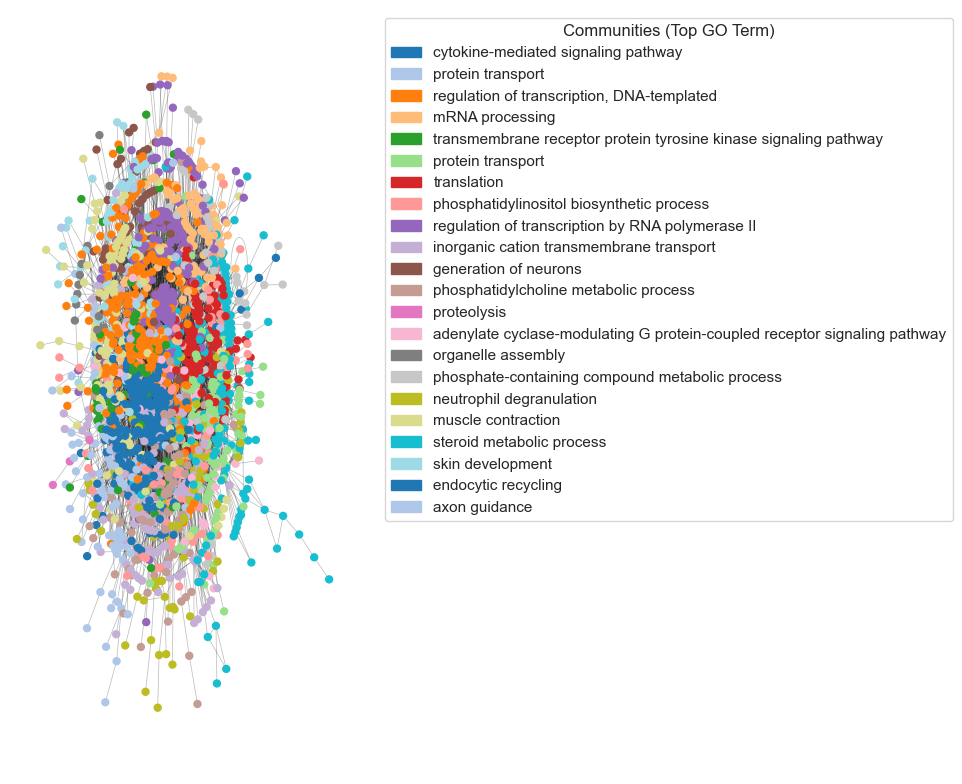

In [59]:
# Load the CSV file that contains the community-to-top-GO-term mapping
df_go = pd.read_csv('communities_louvain_with_topGO.csv')

# Clean the 'Top GO Term' column to remove GO IDs and keep only the process name
# Example: "GO:0008150~biological_process" -> "biological_process"
# df_go['Top GO Term'] = df_go['Top GO Term'].str.extract(r'~(.*)', expand=False).fillna(df_go['Top GO Term'])
# Clean the 'Top GO Term' column to remove the GO ID in parentheses
# Example: "N-terminal protein amino acid acetylation (GO:0006474)" → "N-terminal protein amino acid acetylation"
df_go['Top GO Term'] = df_go['Top GO Term'].str.replace(r'\s*\(GO:\d+\)', '', regex=True).str.strip()


# Create a dictionary mapping each community ID to its cleaned top GO biological term
community_to_go = dict(zip(df_go['Community'], df_go['Top GO Term']))

# Get the unique community identifiers from the partition dictionary
unique_coms = sorted(set(partition.values()))
num_coms = len(unique_coms)

# Generate a color palette using seaborn (tab20 supports up to 20 distinct colors)
palette = sns.color_palette("tab20", n_colors=num_coms)
color_map = [tuple(c) for c in palette]

# Assign a color to each community
community_to_color = {com: color_map[i] for i, com in enumerate(unique_coms)}

# Assign node colors based on their community from the partition
node_colors = [community_to_color[partition[n]] for n in G.nodes()]

# Compute node positions using Kamada-Kawai layout
pos = nx.kamada_kawai_layout(G)

# Create a new figure for the plot
plt.figure(figsize=(10, 8))

# Draw nodes with their assigned colors
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=25, alpha=1.0)

# Draw edges with transparency
nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.5)

# Turn off axis display
plt.axis('off')

# Create a legend with community colors and their top GO terms
legend = [
    mpatches.Patch(
        color=community_to_color[com],
        label=community_to_go.get(com, f"Community {com}")
    )
    for com in unique_coms
]

# Add the legend to the right of the plot
plt.legend(
    handles=legend,
    title="Communities (Top GO Term)",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

**Session information:**

In [127]:
!python --version

Python 3.12.1


In [128]:
!pip list

Package                   Version
------------------------- ---------
adjustText                1.0.4
asttokens                 2.4.1
attrs                     25.3.0
certifi                   2025.4.26
charset-normalizer        3.4.2
colorama                  0.4.6
comm                      0.2.2
contourpy                 1.2.0
cycler                    0.12.1
debugpy                   1.8.2
decorator                 5.1.1
docopt                    0.6.2
et_xmlfile                2.0.0
executing                 2.0.1
fastjsonschema            2.21.1
fonttools                 4.47.2
ftpretty                  0.4.0
goatools                  1.4.12
gseapy                    1.1.8
idna                      3.10
ipykernel                 6.29.5
ipython                   8.26.0
jedi                      0.19.1
joblib                    1.4.2
jsonschema                4.23.0
jsonschema-specifications 2025.4.1
jupyter_client            8.6.2
jupyter_core              5.7.2
kiwisolver         


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
